# Lasers Parameter Calculations
Notebook with basic calculations that are useful for (pulsed) laser experiments.

* Basic calculations - evaluate the applied fluence/energy/intensity
* Spot size vs distance from the focal plane - useful for calculating defocusing distances when a larger laser spot is required for a given lens
* Specific functions for the deposition system in B11

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# Basic Calculations
Evaluate the laser energy, fluence and intensity
* Laser energy is measured with a pyroelectric energy meter
* Beam waist is determined either theroetically, via D2-LnF measurements or by direct viewing with a CCD - latter is better if the spot is not circular, i.e. an ellipse when the laser is not incident normal onto the target surface
* Laser pulse width can either be determined via FGROG/autocorrelation measurements or taken from the laser specifications

In [2]:
# Functions
def E(F, area):
    """Convert average fluence [J/cm2] to pulse energy [J]"""
    return F * area

def F(E, area):
    """Convert pulse energy [J] and beam waist [cm] to average fluence [J/cm2]"""
    return E/area

def F_peak(E, area):
    """Convert pulse energy [J] and beam waist [cm] to peak fluence [J/cm2] assuming Gaussian intensity profile"""
    return 2*F(E, area)

In [3]:
# Evaluate average fluence
E = 120E-6  # Energy of the pulse
w0 = 220E-4/2  # Beam waist [cm]
area = np.pi * w0**2  # Beam area assuming a circle [cm2]
print('Average Fluence = {:.2g} J/cm2'.format(F(E, area)))

Average Fluence = 0.32 J/cm2


In [4]:
# Evaluate intensity
t = 100E-15  # Pulse width [s]
print('Laer Intensity = {:.2g} J/(cm2•s)'.format(F(E, area)/t))

Laer Intensity = 3.2e+12 J/(cm2•s)


# Spot size vs distance from the focal plane

To theoretically calculate the Beam Waist, w0 [mm], at the foal plane given the input beam parmeters and lens use the calculator at http://www.calctool.org/CALC/phys/optics/f_NA

Calculations are taken from:
* https://www.edmundoptics.com/resources/tech-tools/gaussian-beams/
* http://www.colorado.edu/physics/phys4510/phys4510_fa05/Chapter5.pdf

In [9]:
(800E-3 * 56.5E-4) / (np.pi*.75E-4)

19.183475807343118

In [5]:
# Functions
def z_R(w0, lam):
    """Rayleigh Range, z_R (mm)"""
    return np.pi * w0**2 / (lam*1E-6)

def w(z, w0, z_R):
    """Half Beam Diameter, w(z) (mm)"""
    return w0 * np.sqrt(1 + (z/z_R)**2)

def theta(lam, w0):
    """Half Angle Divergence, θ (mrad)"""
    return lam*1E-3 / (np.pi*w0)

Text(0,0.5,'w(z) [mm]')

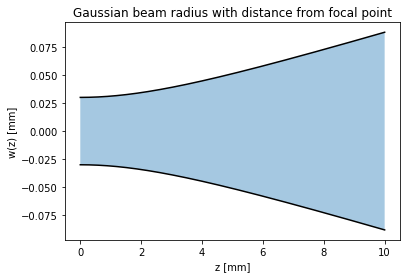

In [6]:
# Plot the beam waist vs position from focal plane
w0 = 60E-3 / 2  # Beam Waist, w0 [mm]
lam = 780  # Laser Wavelength, λ (nm)
z = np.linspace(start=0, stop=10, num=1000)  # Distance from focal plane to plot over [mm]

# Calculations and plot
fig, ax = plt.subplots()
y = w(z, w0, z_R(w0, lam))
ax.plot(z, y, z, -y, color='black')
ax.fill_between(z, y, -y, alpha=0.4)
ax.set_title('Gaussian beam radius with distance from focal point')
ax.set_xlabel('z [mm]')
ax.set_ylabel('w(z) [mm]')

In [32]:
# To get beam waist at a specific point
z = 6
y = w(z, w0, z_R(w0, lam))
print('w0(z={:.4g} mm) = {:.4g} um'.format(z, y*1E3))

w0(z=6 mm) = 58.02 um


# B11 System

In [4]:
# Spot size (major axis)
D = 75  # minor axis diameter (normal to beam)
AOI = 70  # degrees

r_minor = D / 2
r_major = 0.5 * D / np.sin(np.deg2rad(90-AOI))

In [20]:
# Fluence in major and minor axis
E = 200E-6
print('Fluence in major {:.3g} J/cm2 and minor {:.3g} J/cm2 axis'.format(F_avg(E, r_major*1E-4), F_avg(E, r_minor*1E-4)))

Fluence in major 0.53 J/cm2 and minor 4.53 J/cm2 axis


In [12]:
# Pulser per spot/area
v = 1.5  # mm/s
f = 1E3  # Rep rate of laser [Hz]
D = 75E-3  # mm

# Average pulses per area = length drawn per sec / rastering speed
f*D / v  # mm/s

50.0

In [ ]:
# [Femtosecond laser volume ablation rate and threshold measurements by differential weighing]

C = 1E3     # Rep rate of laser [Hz]
L_path = 20  # Length of raster path (line length x number of of lines) [mm]
k = 10      # number of passes
v = 10      # Velocity of raster [mm/s]

# Number of pulses used to machine sample
Np = C * L_path * k / v

rho = 2.2  # Density of sample [g/cm3]
m = 10     # Change in mass [g]

# Ablated volume
vol = m / (rho*Np)

# Misc
## Beam through aperture at lens focal plane
Sometimes the beam quality in the tails coming out the laser is poor and so one can pass the beam through an aperture to truncate the tails, just before the focusing lens, to improve the shape of the focal spot. Ablation experiments, such as D2-LnF measurements, require a good focal spot.

The following code replicates the calculation in the paper "Femtosecond laser ablation properties of borosilicate glass, Yakar" to evaluate the change in energy density of a truncated Gaussian beam at the focal plane of the objective lens.

In [10]:
from scipy.special import j0
from scipy.integrate import quad

def F(r, w, f, lam, a, E):
    k = (2 * np.pi * w) / ( f * lam)
    
    def func(rho, k, r):
        return rho * np.exp(-rho**2) * j0(k*r*rho)
    
    integral = quad(func, 0, a/w, args=(k, r))[0] **2
    
    return (2*E*k**2/np.pi) * integral

w = 7E-3 / 2
f = 40E-3
lam = 780E-9
a = 7E-3 / 2
E = 100E-6

r = np.linspace(0, 10E-6, num=1000)
vF = np.vectorize(F)
y = vF(r, w, f, lam, a, E)

fig, ax = plt.subplots()
ax.plot(r, y)

a = 5.5E-3/ 2
y2 = vF(r, w, f, lam, a, E)
ax.plot(r, y2)